## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv('./data/marketing_campaign.csv', delimiter = '\t')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## Data Preprocessing

### Cleaning and Outliers

In [4]:
#checking for nulls
df.isna().sum().sum()

24

In [5]:
#finding the column(s) with nulls
nulls = df.isna().sum()
nulls[nulls != 0]

Income    24
dtype: int64

In [6]:
#number of observations in dataset
df.shape[0]

2240

Since the null values are extremely small, I will drop them from the dataset. The `Income` column will not be drastically affected since there are only 24 missing values in it, indicating that they were mostly missing at random, as the ratio of missing values is small compared to the entire observations in the dataset.

In [7]:
df.dropna(inplace = True)

In [8]:
#checking to see if it worked
df.isna().sum().sum()

0

In [9]:
#veryfing data types reflect what they should reflect
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [10]:
df['Dt_Customer']

0       04-09-2012
1       08-03-2014
2       21-08-2013
3       10-02-2014
4       19-01-2014
           ...    
2235    13-06-2013
2236    10-06-2014
2237    25-01-2014
2238    24-01-2014
2239    15-10-2012
Name: Dt_Customer, Length: 2216, dtype: object

The `Dt_Customer` column is currently stored as an object data type rather than a datetime object. I will update this column to datetime format, rename it, and correct the date format from 'd-m-y' to 'm-d-y'.

In [11]:
#converting to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

#reformatting to 'm-d-y'
df['Dt_Customer'] = df['Dt_Customer'].dt.strftime('%m-%d-%Y')

#renaming
df.rename(columns={'Dt_Customer': 'Enrollment'}, inplace = True)

In [12]:
#checking to see if it worked
df['Enrollment']

0       09-04-2012
1       03-08-2014
2       08-21-2013
3       02-10-2014
4       01-19-2014
           ...    
2235    06-13-2013
2236    06-10-2014
2237    01-25-2014
2238    01-24-2014
2239    10-15-2012
Name: Enrollment, Length: 2216, dtype: object

In [13]:
#back to datetime
df['Enrollment'] = pd.to_datetime(df['Enrollment'])
df['Enrollment'].dtypes

dtype('<M8[ns]')

This is a NumPy datetime data type so everything did work! 

In [14]:
#renaming more columns
df=df.rename(columns={"MntWines": "Wines",
                      "MntFruits":"Fruits",
                      "MntMeatProducts":"Meats",
                      "MntFishProducts":"Fish",
                      "MntSweetProducts":"Sweets",
                      "MntGoldProds":"Gold",
                      'NumDealsPurchases':'DiscountPurchases',
                      'NumWebPurchases': 'WebPurchases',
                      'NumCatalogPurchases':'CatalogPurchases', 
                      'NumStorePurchases':'StorePurchases', 
                      'NumWebVisitsMonth':'WebVisits'})
#removing unneeded columns
df.drop(columns = ['Z_CostContact','Z_Revenue'], inplace = True)

#### Outliers

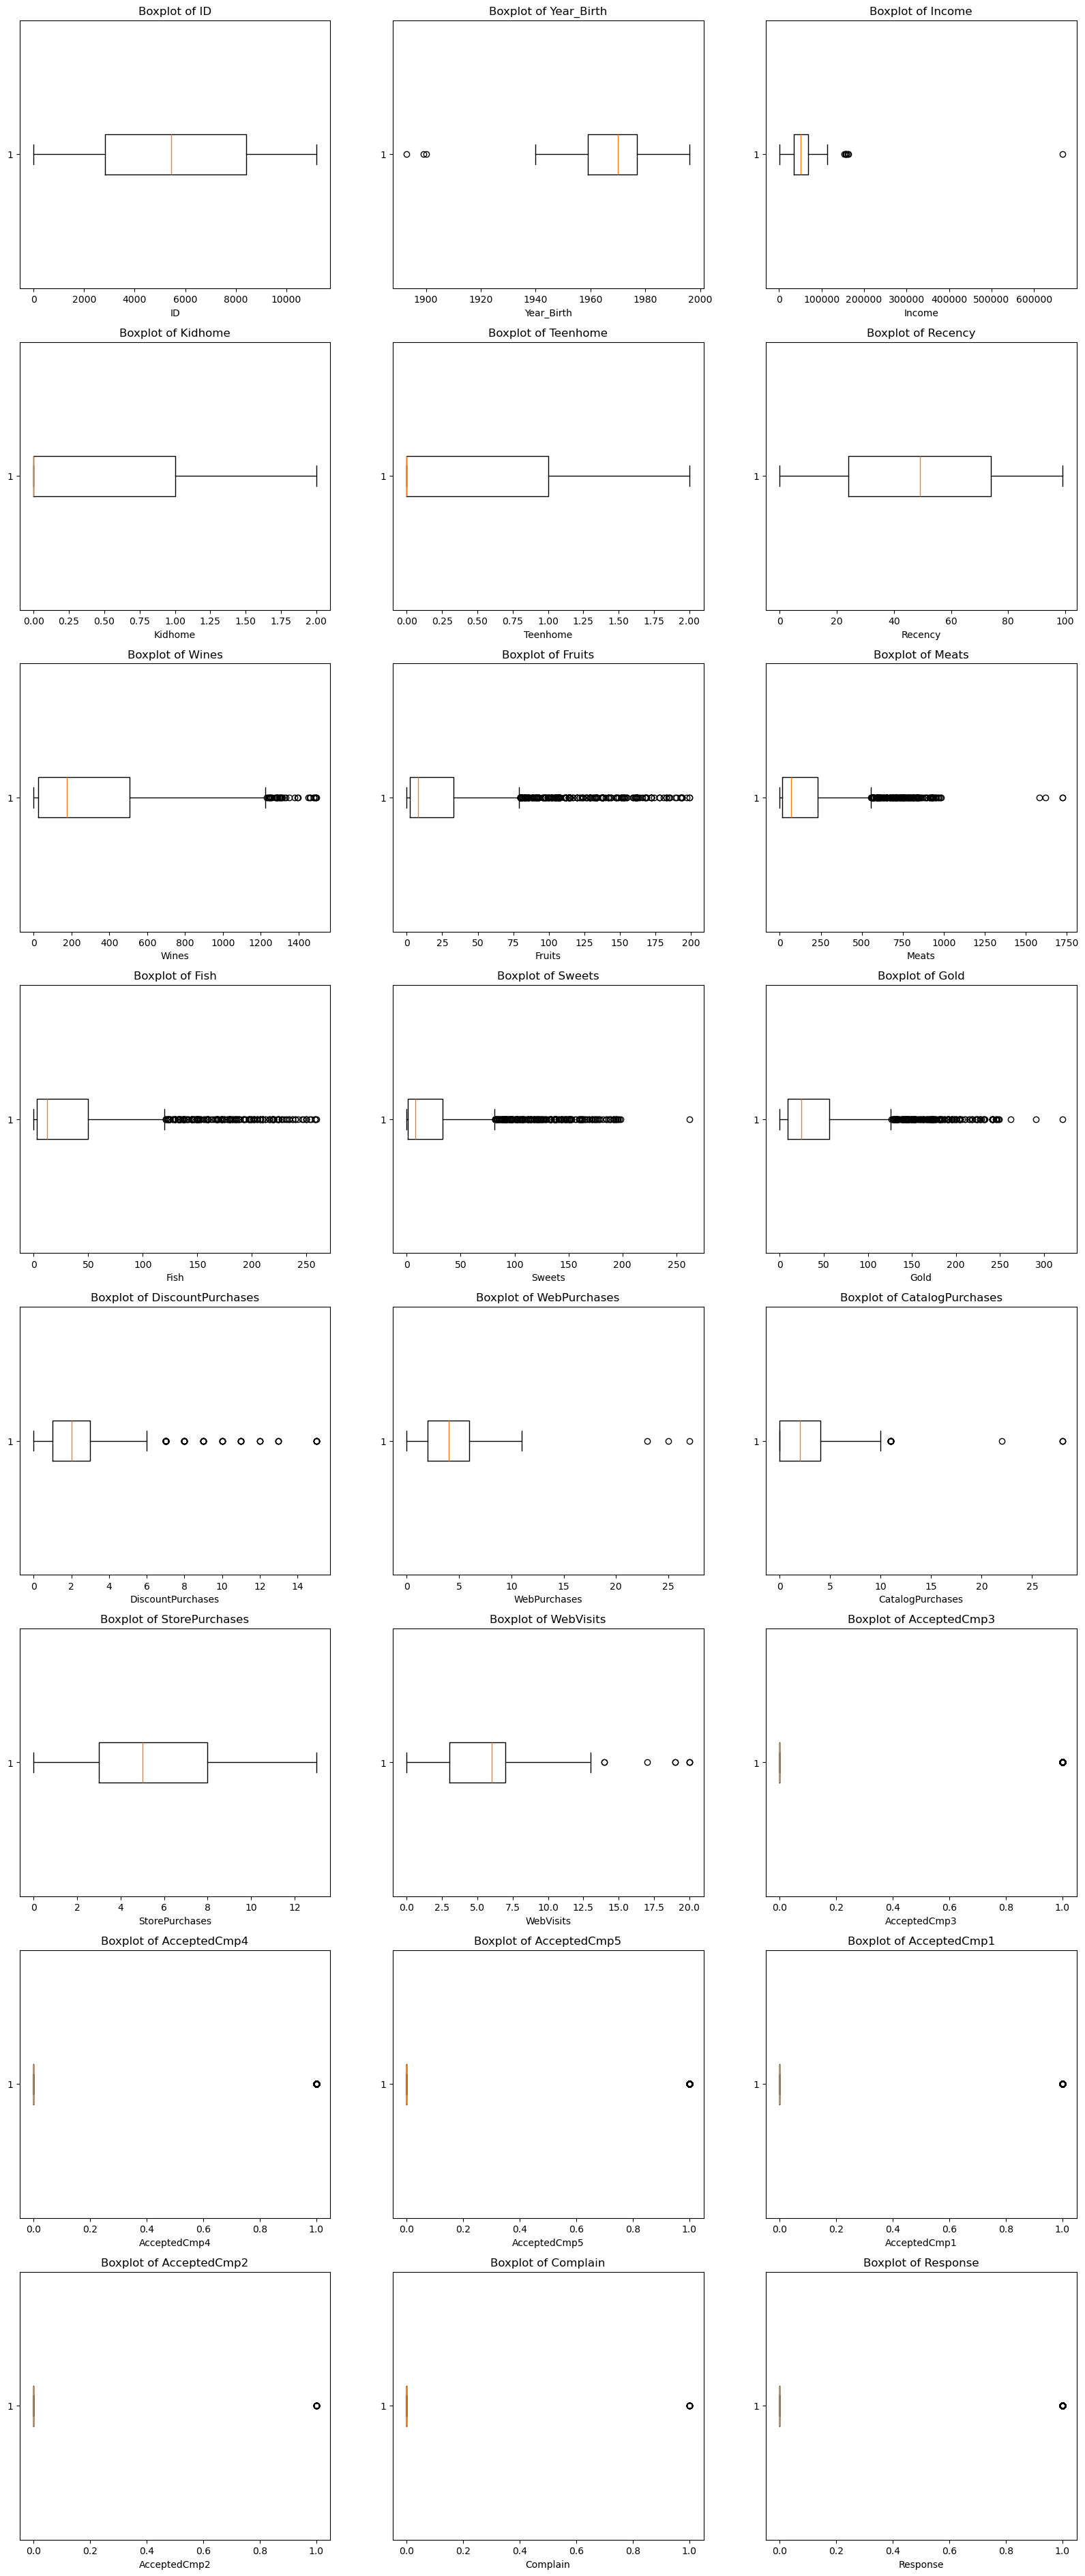

In [15]:
#finding columns that might have outliers by looking at it's distribution
num_cols = df.select_dtypes(include='number').columns.to_list()

num_rows = (len(num_cols) + 1) // 3

#creating boxplot of columns to visually see outliers
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, num_rows * 6))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    ax = axs[i]
    ax.boxplot(df[col], vert = False)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel(col)

There are columns such as `ID` and `AcceptedCmp3` that are unlikely to have outliers in a traditional sense. `ID` is simply the customer's identifier, and `AcceptedCmp3` are just binaries regarding whether a customer accepted the the offer in the 3rd campaign. Because of this, I will not apply outlier technqiues to such columns. For columns with actual, potential, outliers, I will remove the values outside of the lower and upper bounds to account for outliers

In [16]:
#list of columns with potential outliers
outliers = num_cols
not_outlier = (['ID', 'Kidhome', 'Teenhome', 'Recency',
                'StorePurchases', 'AcceptedCmp3',
                'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1', 
                'AcceptedCmp2','Complain','Response'])
for name in not_outlier:
    if name in outliers:
        outliers.remove(name)
outliers

['Year_Birth',
 'Income',
 'Wines',
 'Fruits',
 'Meats',
 'Fish',
 'Sweets',
 'Gold',
 'DiscountPurchases',
 'WebPurchases',
 'CatalogPurchases',
 'WebVisits']

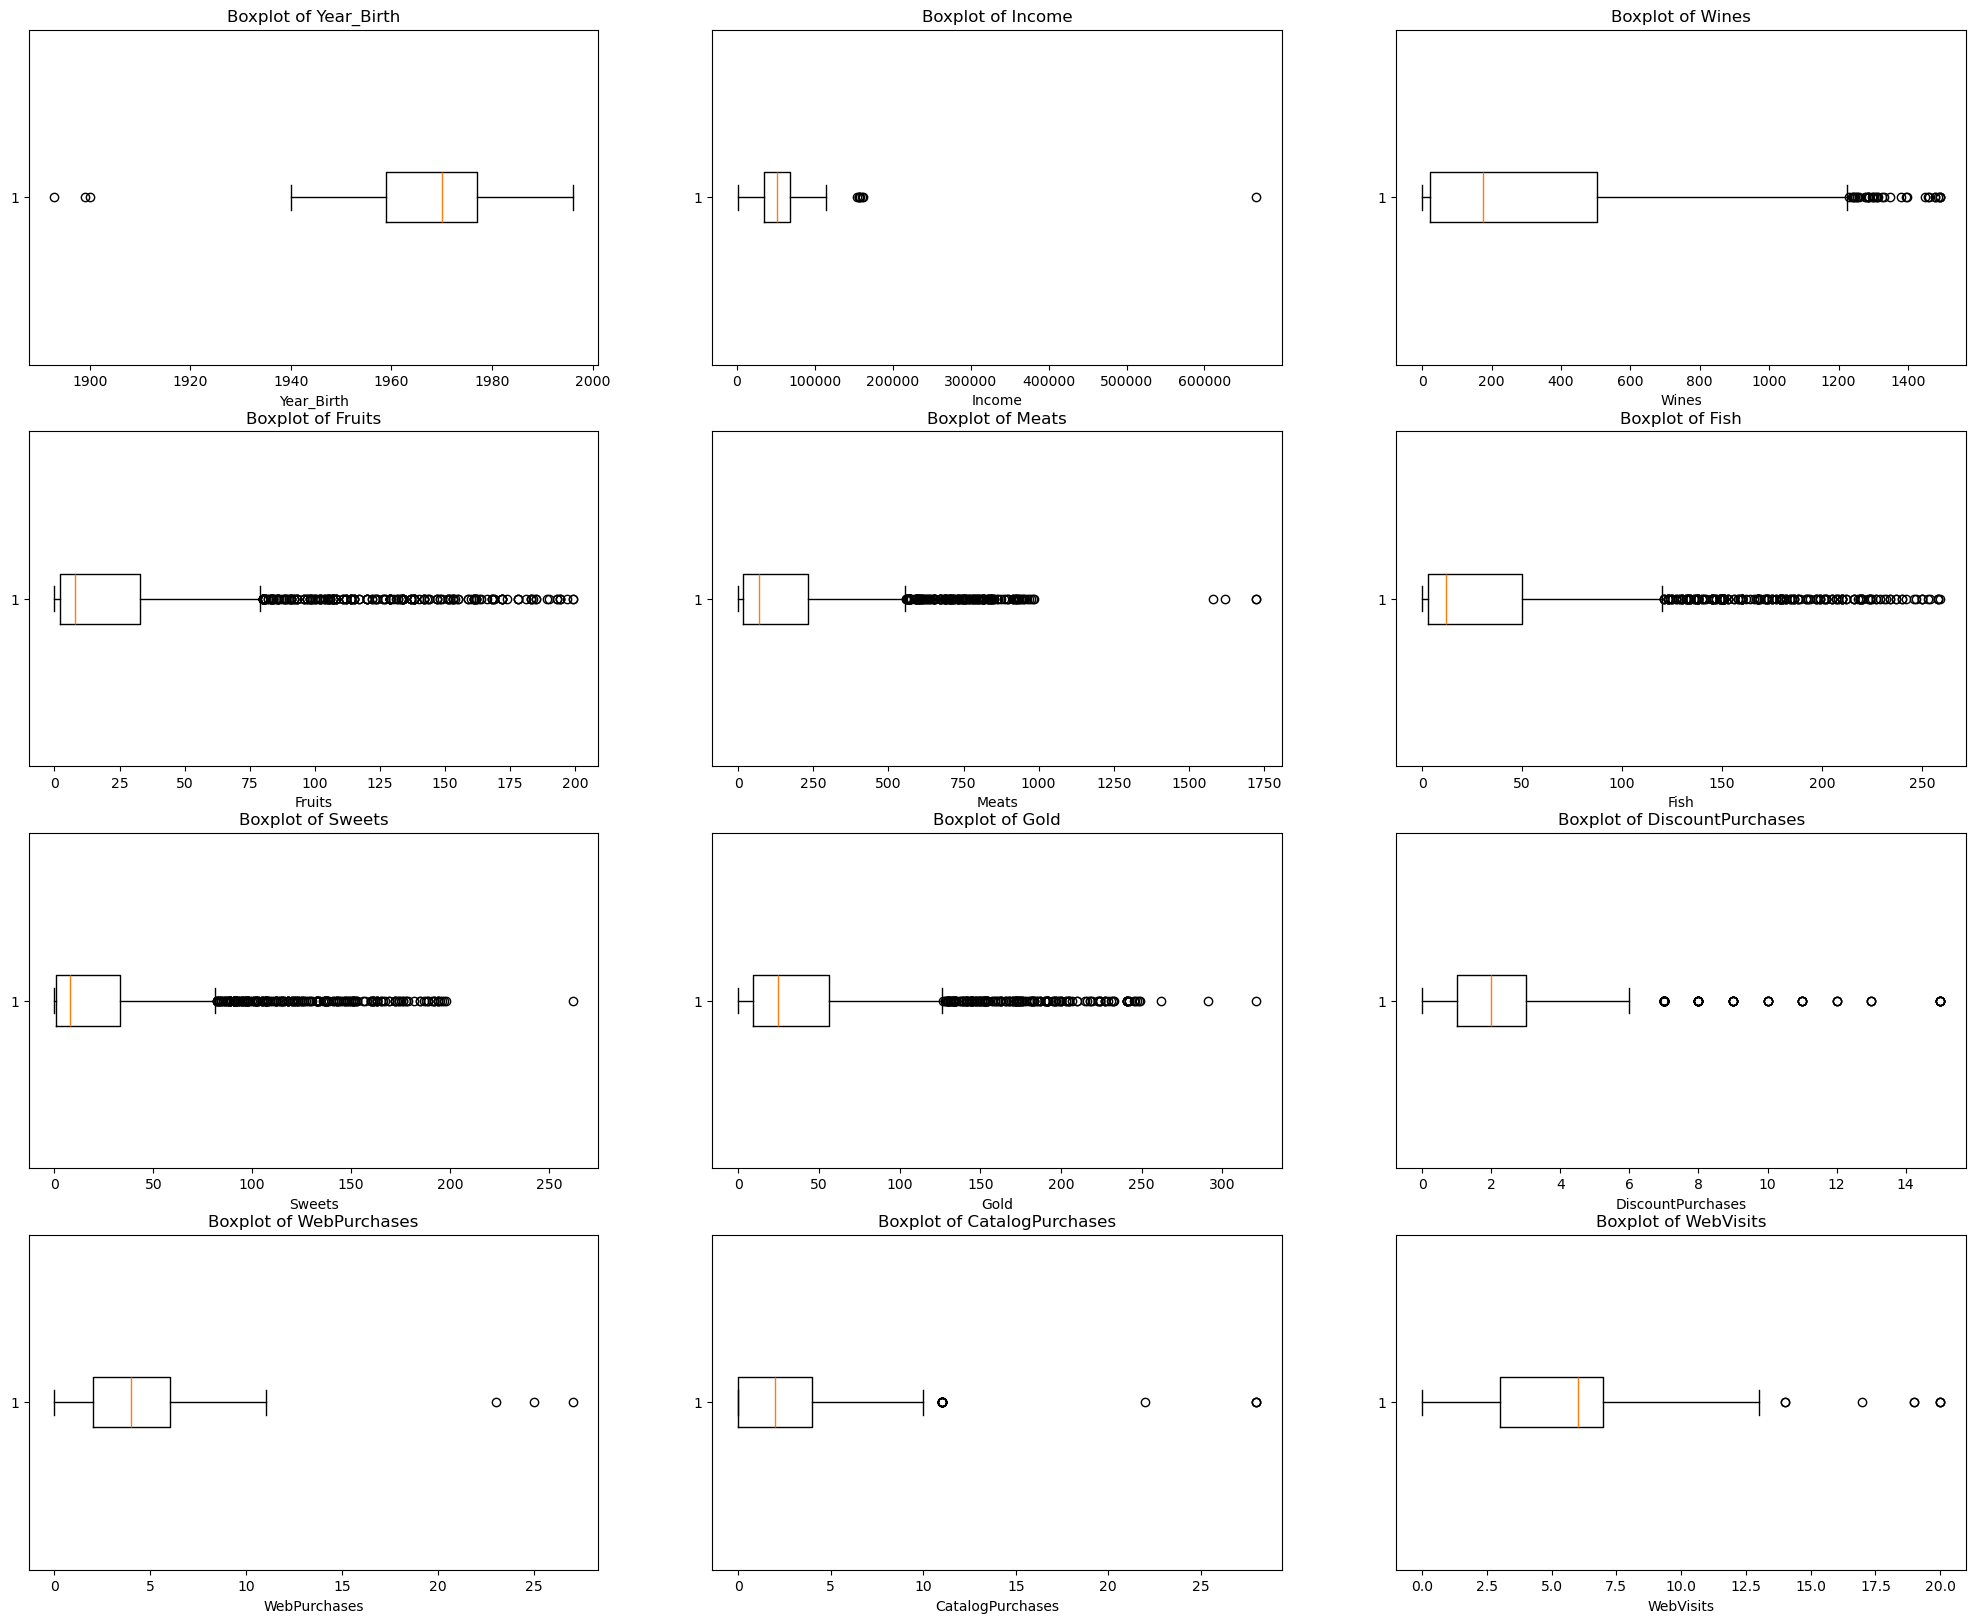

In [17]:
#only showing columns that have outliers
num_rows = (len(outliers) + 1) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(25, 20))
axs = axs.flatten()

for i, col in enumerate(outliers):
    ax = axs[i]
    ax.boxplot(df[col], vert = False)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel(col)

Columns with Upper Bound Outliers:
- Income
- Wines
- Fruits
- Meats
- Fish
- Sweets
- Gold
- DiscountPurchases
- Web Purchases
- CatelogPurchases
- Web Visits

Columns with Lower Bound Outliers
- Year_Birth

In [18]:
#finding the IQR bounds so I can trim the data
bounds = {}

for col in outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    bounds[col] = {'Lower Bound': lower_bound, 'Upper Bound': upper_bound}

bounds_df = pd.DataFrame(bounds)

#transposing so original df columns are the idx and bounds are the columns for easier viewing 
bounds_df = bounds_df.transpose()
bounds_df

,Lower Bound,Upper Bound
Year_Birth,1932.000,2004.000
Income,-14525.500,118350.500
Wines,-697.500,1226.500
Fruits,-44.500,79.500
Meats,-308.375,556.625
Fish,-67.500,120.500
Sweets,-47.000,81.000
Gold,-61.500,126.500
DiscountPurchases,-2.000,6.000
WebPurchases,-4.000,12.000


In [19]:
#trimming the columns at the appropriate bound where the outliers are
for col in outliers:
    lower_bound = bounds_df.at[col, 'Lower Bound']
    upper_bound = bounds_df.at[col, 'Upper Bound']
    if col == 'Year_Birth':
        df = df[df[col] > lower_bound]
    else:
        df = df[df[col] < upper_bound]


### Feature Engineering

In [20]:
#looking to see if i can transform columns into newer ones
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Enrollment', 'Recency', 'Wines', 'Fruits', 'Meats', 'Fish',
       'Sweets', 'Gold', 'DiscountPurchases', 'WebPurchases',
       'CatalogPurchases', 'StorePurchases', 'WebVisits', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response'],
      dtype='object')

#### Age

In [21]:
#customer's age
df.insert(1,'Age', 2024-df['Year_Birth'])

In [22]:
#finding the customer's age at time of enrollment
enroll_year = df['Enrollment'].dt.year
df.insert(2, 'Enrollment_Age', enroll_year - df['Year_Birth'])
df.drop(columns = 'Year_Birth', inplace = True) #dropping year birth column as it's no longer needed

#### Household and Marital Status

In [24]:
#combining kidhome and teenhome to create the total dependents column 
df.insert(5, 'Tot_Dependents', df['Kidhome'] + df['Teenhome'])
df.drop(columns = ['Kidhome', 'Teenhome'], inplace = True)

In [25]:
df['Has_Dependents'] = df.apply(lambda x : 1 if x['Tot_Dependents'] > 0 else 0, axis=1)

In [26]:
#diving deeper into marital status
df['Marital_Status'].value_counts()

Marital_Status
Married     565
Together    379
Single      307
Divorced    148
Widow        46
Alone         3
YOLO          2
Name: count, dtype: int64

In [27]:
#recategorizing to be succinct
df['Marital_Status'].replace({'Married': 'Partnership',
                              'Together': 'Partnership',
                              'Single': 'No_Partner',
                              'Divorced': 'No_Partner',
                              'Widow': 'No_Partner',
                              'Alone':'No_Partner',
                              'Absurd': 'No_Partner',
                              'YOLO': 'No_Partner'}, inplace=True)

In [28]:
#creating household size col
df["Adults"] = df["Marital_Status"].replace({"Partnership": 2, "No_Partner":1})
df.insert(6,'Household_Size', df['Adults'] + df['Tot_Dependents'])
df.drop('Adults', axis =1, inplace = True) #dropping because it wont be needed

#### Income

In [29]:
#categorizing the income levels (based on https://finance.yahoo.com/news/income-fall-americas-lower-middle-122100515.html_)
def income_leveler(column):
    if column < 30_000:
        return 'low income'
    elif 30_001 <= column <= 58_020:
        return 'lower-middle income'
    elif 58_021 <= column <= 94_000:
        return 'middle income'
    elif 94_001 <= column <= 153_000:
        return 'upper-middle class'
    elif column > 153_000:
        return 'high income'
    else: 
        return 'unknown' 
        
df.insert(8, 'Income_Level', df['Income'].apply(income_leveler))

#### Education

In [30]:
df['Education'].value_counts()

Education
Graduation    683
PhD           336
Master        254
2n Cycle      125
Basic          52
Name: count, dtype: int64

In [31]:
#recategorizing to be succinct
df['Education'].replace({'Graduation': 'Bachelor',
                              '2n Cycle': 'Master', #classified with help from https://www.studera.nu/startpage/higher-education/sweden/levels-degrees/#;h20
                              'Basic': 'High School',
                        }, inplace=True)

In [32]:
df['Education'].value_counts()

Education
Bachelor       683
Master         379
PhD            336
High School     52
Name: count, dtype: int64

#### Purchases and Spending

In [33]:
#total spending
df.insert(9,'Tot_Spent', df['Wines'] + df['Fruits'] + df['Meats'] + df['Fish'] + df['Sweets'] + df['Gold'])
#total amt purchased
df.insert(10,'Tot_Purchased', df['DiscountPurchases'] + df['WebPurchases'] + df['CatalogPurchases'] + df['StorePurchases'])

#### Promotions

In [34]:
df['Tot_AccptCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

#### Loyalty

In [35]:
df['Days_Enrolled'] = (pd.Timestamp.now() - df['Enrollment']).dt.days

## Exporting Cleaned DF to CSV

In [36]:
df.to_csv('./data/cleaned_df.csv', index = False)